In [1]:
using LinearAlgebra
using Statistics
using Plots
using ProgressMeter
using PyCall

In [2]:
function generateShapleyGame(beta)
    A = Matrix(1.0I, 3, 3)
    A[1, 3] = beta
    A[2, 1] = beta
    A[3, 2] = beta
    
    B = Matrix(-beta*1I, 3, 3)
    B[1, 2] = 1
    B[2, 3] = 1
    B[3, 1] = 1
    
    return (A, B)
end

generateShapleyGame (generic function with 1 method)

In [2]:
py"""
def generateGallaGames(gamma, nSim, nAct):
    import numpy as np

    nElements = nAct ** 2  # number of payoff elements in the matrix

    cov = np.eye(2 * nElements)  # <a_ij^2> = <b_ji^2> = 1
    cov[:nElements, nElements:] = np.eye(nElements) * gamma  # <a_ij b_ji> = Gamma
    cov[nElements:, :nElements] = np.eye(nElements) * gamma

    rewardAs, rewardBs = np.eye(nAct), np.eye(nAct)

    for i in range(nSim):
        rewards = np.random.multivariate_normal(np.zeros(2 * nElements), cov=cov)

        rewardAs = np.dstack((rewardAs, rewards[0:nElements].reshape((nAct, nAct))))
        rewardBs = np.dstack((rewardBs, rewards[nElements:].reshape((nAct, nAct)).T))
    return [rewardAs[:, :, 1:], rewardBs[:, :, 1:]]
"""

generateGallaGames(gamma, nSim, nAct) = py"generateGallaGames"(gamma, nSim, nAct)

generateGallaGames (generic function with 1 method)

In [3]:
function generateStochasticGame(dims)
    A = rand(dims, dims)
    while ( any(sum(A, dims = 1) .- 1.0 .> 1e-6) || any(sum(A, dims = 2) .- 1.0 .> 1e-6) )
        A = A ./ sum(A, dims = 1)
        A = A ./ sum(A, dims = 2)
    end

    B = rand(dims, dims)
    while ( any(sum(B, dims = 1) .- 1.0 .> 1e-6) || any(sum(B, dims = 2) .- 1.0 .> 1e-6) )
        B = B ./ sum(B, dims = 1)
        B = B ./ sum(B, dims = 2)
    end
    
    return (A, B)
end

generateStochasticGame (generic function with 1 method)

In [5]:
py"""
def findNE(A, B):
    import nashpy as nash
    rps = nash.game(A, B)
    eqs = rps.support_enumeration()
    return list(eqs)
"""

findNE(A, B) = py"findNE"(A, B)

findNE (generic function with 1 method)

In [ ]:
generateGallaGames(-1, 1, 3)

In [ ]:
pyimport("nashpy")

In [172]:
function FPUpdateX(A, avgY)
    return findmax(I * A * avgY)[2]
end

function FPUpdateY(B, avgX)
    return findmax(transpose(avgX) * B * I)[2][2]
end

FPUpdateY (generic function with 1 method)

In [4]:
function simulation(beta, dim, nIter=5e4)
    
    A, B = generateStochasticGame(dim)
    
    NEX, NEY = dot(ones(dim) .* (1/dim), A* ones(dim) .* (1/dim)), 
               dot(ones(dim) .* (1/dim), B* ones(dim) .* (1/dim))
    
    pX, qY = zeros(dim), zeros(dim)
    pX[rand(1:dim)] = 1
    qY[rand(1:dim)] = 1

    rX, rY = [],  []
    avgRX, avgRY = [], []
    for n = 1:nIter
        eX, eY = zeros(dim), zeros(dim)
        eX[argmax(A * qY)] = 1
        eY[argmax(transpose(transpose(pX) * B))] = 1

        pX = (n .* pX + eX) ./ (n+1)
        qY = (n .* qY + eY) ./ (n+1)
                
        rX = [rX; transpose(pX) * A * qY]
        rY = [rY; transpose(pX) * B * qY]
        
        avgRX = [avgRX; sum(rX)/length(rX) - NEX]
        avgRY = [avgRY; sum(rY)/length(rY) - NEY]
    end
    
    return avgRX, avgRY
end

simulation (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:34:48


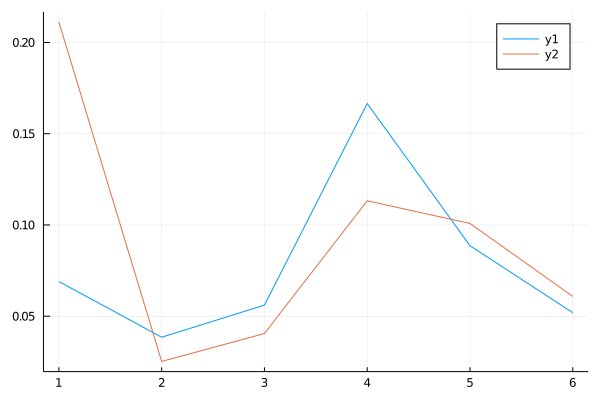

In [5]:
payoffTrackerX = []
payoffTrackerY = []

@showprogress for dims = 3:8
    rX, rY = simulation(0, dims)
    payoffTrackerX = [payoffTrackerX; rX[end]]
    payoffTrackerY = [payoffTrackerY; rY[end]]
end
plot(payoffTrackerX)
plot!(payoffTrackerY)

In [ ]:
proj = [-1 * cos(30 / 360 * 2 * pi) cos(30 / 360 * 2 * pi) 0;
        -1 * sin(30 / 360 * 2 * pi) -1*sin(30 / 360 * 2 * pi) 1]

ts = collect(LinRange(0, 1, 10000))
d1 = proj * [ts, 1 .- ts, 0 .* ts]
d2 = proj * [0 .* ts, ts, 1 .- ts]
d3 = proj * [ts, 0 .* ts, 1 .- ts]

In [12]:
plot!(rX)
plot!(rY)

In [ ]:
plot(d1[1], d1[2])
plot!(d2[1], d2[2])
plot!(d3[1], d3[2])

In [ ]:
plot!((proj * allPX)[1, :], (proj * allPX)[2, :])

In [ ]:
plot!((proj * allPY)[1, :], (proj * allPY)[2, :])